# 读取数据

In [1]:
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *

In [2]:
import pickle
df1 = pickle.load(open('df5_results1.pkl', 'rb'))
df2 = pickle.load(open('df5_results2.pkl', 'rb'))
df3 = pickle.load(open('df5_results3.pkl', 'rb'))
df4 = pickle.load(open('df5_results4.pkl', 'rb'))
df5 = pickle.load(open('df5_results5.pkl', 'rb'))
df6 = pickle.load(open('df5_results6.pkl', 'rb'))
df7 = pickle.load(open('df5_results7.pkl', 'rb'))

In [3]:
import pandas as pd
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

In [4]:
df.head()

,images,activity,person
0,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
1,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
2,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
3,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36
4,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36


In [5]:
df.shape

(3397, 3)

按类别名称进行编码：

In [6]:
from sklearn.preprocessing import LabelEncoder
activity_encoder = LabelEncoder()
df['activity_label'] = activity_encoder.fit_transform(df['activity'])

In [7]:
person_encoder = LabelEncoder()
df['person_label'] = person_encoder.fit_transform(df['person'])

In [8]:
df.head()

,images,activity,person,activity_label,person_label
0,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
1,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
2,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
3,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35
4,F:\Github\radar_HAR\images_5seconds\1\1P36A01R...,1,36,0,35


In [9]:
max(df['activity_label'])

5

In [10]:
max(df['person_label'])

71

# Person classification

In [11]:
X_col = 'images'

In [12]:
y_col = 'person_label'  

进行数据集的划分：

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 按照y进行分层采样
# 20%的数据作为测试集
for train_index, test_index in split.split(df, df[y_col]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [14]:
strat_train_set.shape

(2717, 5)

In [15]:
strat_test_set.shape

(680, 5)

接下来利用ImageDataGenerator来准备训练用的generator

In [16]:
# 图像归一化
# 并且划分20%的训练集数据作为验证集数据
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 设置小批量的大小
batch_size = 32
# 统一图片的分辨率
target_size = (75, 125)


train_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col=X_col,
                                            y_col=y_col,
                                            subset="training",
                                            seed=44,  # 随机数种子
                                            class_mode="raw",
                                            color_mode="grayscale",  # 按照灰度图处理
                                            target_size=target_size,  
                                            batch_size=batch_size) # batch_size

# 划分验证集
valid_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col=X_col,
                                            y_col=y_col,
                                            subset="validation",
                                            seed=44,  # 随机数种子
                                            class_mode="raw",
                                            color_mode="grayscale",  # 按照灰度图处理
                                            target_size=target_size,  
                                            batch_size=batch_size) # batch_size

Found 2174 validated image filenames.
Found 543 validated image filenames.


分别查看训练集和验证集的数量：

In [17]:
train_generator.n

2174

In [18]:
train_generator.batch_size

32

In [19]:
valid_generator.n

543

In [20]:
valid_generator.batch_size

32

In [21]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape)
    print(y_batch.shape)
    break

(32, 75, 125, 1)
(32,)


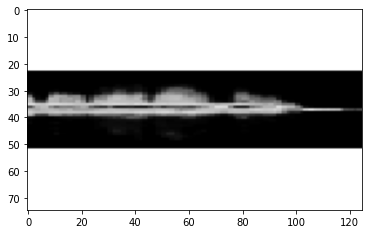

In [22]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_batch[0][:,:,0], cmap='gray')

In [23]:
y_batch[0]

19

构建test_generator

In [24]:
# 图像归一化
datagen=ImageDataGenerator(rescale=1./255)


test_generator=datagen.flow_from_dataframe(dataframe=strat_test_set, 
                                            x_col=X_col,
                                            y_col=y_col,
                                            class_mode="raw",
                                            color_mode="grayscale",  # 按照灰度图处理
                                            target_size=target_size,  # 把图片变小
                                            batch_size=batch_size) # batch_size

Found 680 validated image filenames.


In [25]:
test_generator.n

680

In [26]:
test_generator.batch_size

32

# 模型尝试

定义不同结构的模型并且进行比较：

In [27]:
nb_classes = max(df[y_col]) + 1

In [28]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Flatten, Dropout

In [29]:
def make_model(nb_filters, img_rows, img_cols, nb_classes):
    """
    Make and return the CNN model
    :param nb_filters: Number of filters to use in layers 1,2 and 3,4 respectively
    :type nb_filters: str containing the number of filters for the first two layers followed by 
    the last two layers, for example: "16-32"
    :param img_rows: image height
    :type img_rows: int
    :param img_cols: image width
    :type img_cols: int
    :param nb_classes: Number of classes to be predicted
    :type nb_classes: int
    :return: CNN model
    :rtype: Keras sequential model
    """
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, (3, 3), padding='same', input_shape=(img_rows, img_cols, 1), activation='relu'))
    model.add(Convolution2D(size_1, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(size_2, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(size_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

In [30]:
model = make_model('16-32', 75, 125, nb_classes)

In [31]:
model.summary()

Model: "16-32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 125, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 123, 16)       2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 61, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 61, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 61, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 29, 32)        0     

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 32

history0 = model.fit(train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n // valid_generator.batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/30
67/67 [==============================] - 1s 22ms/step - loss: 4.2792 - accuracy: 0.0177 - val_loss: 4.2626 - val_accuracy: 0.0059
Epoch 2/30
67/67 [==============================] - 1s 18ms/step - loss: 4.2477 - accuracy: 0.0163 - val_loss: 4.2548 - val_accuracy: 0.0078
Epoch 3/30
67/67 [==============================] - 1s 18ms/step - loss: 4.2389 - accuracy: 0.0177 - val_loss: 4.2514 - val_accuracy: 0.0098
Epoch 4/30
67/67 [==============================] - 1s 18ms/step - loss: 4.2375 - accuracy: 0.0215 - val_loss: 4.2527 - val_accuracy: 0.0059
Epoch 5/30
67/67 [==============================] - 1s 18ms/step - loss: 4.2374 - accuracy: 0.0224 - val_loss: 4.2531 - val_accuracy: 0.0098
Epoch 6/30
67/67 [==============================] - 1s 18ms/step - loss: 4.2352 - accuracy: 0.0168 - val_loss: 4.2529 - val_accuracy: 0.0078
Epoch 7/30
67/67 [==============================] - 1s 18ms/step - loss: 4.2333 - accuracy: 0.0159 - val_loss: 4.2538 - val_accuracy: 0.0098
Epoch 8/30
67

In [33]:
history0.history

{'loss': [4.279158115386963,
  4.247737407684326,
  4.238930702209473,
  4.237508773803711,
  4.237351417541504,
  4.235170364379883,
  4.233269691467285,
  4.227224826812744,
  4.228451728820801,
  4.230934143066406,
  4.2208333015441895,
  4.190755844116211,
  4.105012893676758,
  3.983686923980713,
  3.803795576095581,
  3.5853283405303955,
  3.238776445388794,
  2.923203229904175,
  2.592613697052002,
  2.278852701187134,
  1.9790834188461304,
  1.7884008884429932,
  1.4841400384902954,
  1.3421964645385742,
  1.1825557947158813,
  1.0709046125411987,
  0.9414523243904114,
  0.8547623753547668,
  0.7451762557029724,
  0.6962931156158447],
 'accuracy': [0.017740430310368538,
  0.016339870169758797,
  0.017740430310368538,
  0.021475257351994514,
  0.02240896411240101,
  0.016806723549962044,
  0.01587301678955555,
  0.023342670872807503,
  0.017740430310368538,
  0.019607843831181526,
  0.018674137070775032,
  0.023342670872807503,
  0.040616247802972794,
  0.05368814244866371,
  0.

训练集的准确率：

In [34]:
history0.history['accuracy'][-1]

0.7903828024864197

验证集的准确率：

In [35]:
history0.history['val_accuracy'][-1]

0.111328125

然后在测试集上评估：

In [36]:
loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
test_acc

21/21 [==============================] - 0s 14ms/step - loss: 5.7380 - accuracy: 0.1116


0.1116071417927742

定义函数来评估不同结构的模型对应的结果：

In [37]:
def train_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 100
    batch_size = 32

    history = model.fit(train_generator,
              steps_per_epoch=train_generator.n // train_generator.batch_size,
              validation_data=valid_generator,
              validation_steps=valid_generator.n // valid_generator.batch_size,
              epochs=epochs,
              verbose=1)
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
    return train_acc, val_acc, test_acc, history, model

评估不同卷积核大小对应的模型的表现：

In [38]:
model_types = ["2-4", "4-8", "8-16", "16-32", "32-64", "64-128"]

In [39]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
history_list = []
model_list = []

In [40]:
for model_type in model_types:
    model = make_model(model_type, 75, 125, nb_classes)
    train_acc, val_acc, test_acc, history, model = train_model(model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    history_list.append(history)
    model_list.append(model)

Epoch 1/100
67/67 [==============================] - 1s 21ms/step - loss: 4.2720 - accuracy: 0.0173 - val_loss: 4.2606 - val_accuracy: 0.0098
Epoch 2/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2439 - accuracy: 0.0187 - val_loss: 4.2556 - val_accuracy: 0.0137
Epoch 3/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2353 - accuracy: 0.0182 - val_loss: 4.2582 - val_accuracy: 0.0137
Epoch 4/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2241 - accuracy: 0.0210 - val_loss: 4.2437 - val_accuracy: 0.0176
Epoch 5/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2025 - accuracy: 0.0271 - val_loss: 4.2160 - val_accuracy: 0.0254
Epoch 6/100
67/67 [==============================] - 1s 18ms/step - loss: 4.1604 - accuracy: 0.0299 - val_loss: 4.1478 - val_accuracy: 0.0273
Epoch 7/100
67/67 [==============================] - 1s 18ms/step - loss: 4.0717 - accuracy: 0.0355 - val_loss: 4.1105 - val_accuracy: 0.0371
Epoch 

Epoch 15/100
67/67 [==============================] - 1s 18ms/step - loss: 3.0623 - accuracy: 0.2110 - val_loss: 3.7206 - val_accuracy: 0.0840
Epoch 16/100
67/67 [==============================] - 1s 18ms/step - loss: 2.9644 - accuracy: 0.2311 - val_loss: 3.7490 - val_accuracy: 0.0938
Epoch 17/100
67/67 [==============================] - 1s 18ms/step - loss: 2.8449 - accuracy: 0.2563 - val_loss: 3.7671 - val_accuracy: 0.0957
Epoch 18/100
67/67 [==============================] - 1s 18ms/step - loss: 2.7459 - accuracy: 0.2806 - val_loss: 3.7503 - val_accuracy: 0.1152
Epoch 19/100
67/67 [==============================] - 1s 18ms/step - loss: 2.6713 - accuracy: 0.3077 - val_loss: 3.7483 - val_accuracy: 0.0957
Epoch 20/100
67/67 [==============================] - 1s 18ms/step - loss: 2.5938 - accuracy: 0.3128 - val_loss: 3.6982 - val_accuracy: 0.1035
Epoch 21/100
67/67 [==============================] - 1s 18ms/step - loss: 2.4984 - accuracy: 0.3441 - val_loss: 3.7633 - val_accuracy: 0.0898

Epoch 29/100
67/67 [==============================] - 1s 18ms/step - loss: 2.2814 - accuracy: 0.3711 - val_loss: 3.6034 - val_accuracy: 0.1406
Epoch 30/100
67/67 [==============================] - 1s 18ms/step - loss: 2.1815 - accuracy: 0.3880 - val_loss: 3.6026 - val_accuracy: 0.1445
Epoch 31/100
67/67 [==============================] - 1s 18ms/step - loss: 2.0834 - accuracy: 0.4071 - val_loss: 3.5225 - val_accuracy: 0.1504
Epoch 32/100
67/67 [==============================] - 1s 18ms/step - loss: 2.0478 - accuracy: 0.4244 - val_loss: 3.5677 - val_accuracy: 0.1602
Epoch 33/100
67/67 [==============================] - 1s 18ms/step - loss: 1.9829 - accuracy: 0.4472 - val_loss: 3.6648 - val_accuracy: 0.1562
Epoch 34/100
67/67 [==============================] - 1s 18ms/step - loss: 1.8918 - accuracy: 0.4566 - val_loss: 3.6585 - val_accuracy: 0.1484
Epoch 35/100
67/67 [==============================] - 1s 18ms/step - loss: 1.7976 - accuracy: 0.4823 - val_loss: 3.7601 - val_accuracy: 0.1660

Epoch 43/100
67/67 [==============================] - 1s 18ms/step - loss: 0.4191 - accuracy: 0.8693 - val_loss: 5.9103 - val_accuracy: 0.1777
Epoch 44/100
67/67 [==============================] - 1s 18ms/step - loss: 0.4334 - accuracy: 0.8683 - val_loss: 5.9719 - val_accuracy: 0.1484
Epoch 45/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3873 - accuracy: 0.8749 - val_loss: 5.8312 - val_accuracy: 0.1680
Epoch 46/100
67/67 [==============================] - 1s 18ms/step - loss: 0.4541 - accuracy: 0.8641 - val_loss: 5.8825 - val_accuracy: 0.1680
Epoch 47/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3569 - accuracy: 0.8936 - val_loss: 6.1334 - val_accuracy: 0.1680
Epoch 48/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3687 - accuracy: 0.8847 - val_loss: 5.9104 - val_accuracy: 0.1855
Epoch 49/100
67/67 [==============================] - 1s 18ms/step - loss: 0.3639 - accuracy: 0.8861 - val_loss: 5.7198 - val_accuracy: 0.1855

Epoch 57/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2229 - accuracy: 0.0163 - val_loss: 4.2586 - val_accuracy: 0.0078
Epoch 58/100
67/67 [==============================] - 1s 19ms/step - loss: 4.2249 - accuracy: 0.0168 - val_loss: 4.2574 - val_accuracy: 0.0176
Epoch 59/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2231 - accuracy: 0.0177 - val_loss: 4.2627 - val_accuracy: 0.0078
Epoch 60/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2271 - accuracy: 0.0196 - val_loss: 4.2554 - val_accuracy: 0.0176
Epoch 61/100
67/67 [==============================] - 1s 18ms/step - loss: 4.2253 - accuracy: 0.0205 - val_loss: 4.2521 - val_accuracy: 0.0156
Epoch 62/100
67/67 [==============================] - 1s 19ms/step - loss: 4.2250 - accuracy: 0.0177 - val_loss: 4.2596 - val_accuracy: 0.0078
Epoch 63/100
67/67 [==============================] - 1s 19ms/step - loss: 4.2259 - accuracy: 0.0229 - val_loss: 4.2578 - val_accuracy: 0.0078

Epoch 12/100
67/67 [==============================] - 2s 34ms/step - loss: 3.4928 - accuracy: 0.1312 - val_loss: 3.9306 - val_accuracy: 0.0527
Epoch 13/100
67/67 [==============================] - 2s 34ms/step - loss: 3.3393 - accuracy: 0.1625 - val_loss: 3.8826 - val_accuracy: 0.0527
Epoch 14/100
67/67 [==============================] - 2s 34ms/step - loss: 3.1184 - accuracy: 0.2012 - val_loss: 3.7679 - val_accuracy: 0.0820
Epoch 15/100
67/67 [==============================] - 2s 34ms/step - loss: 2.9058 - accuracy: 0.2451 - val_loss: 3.7224 - val_accuracy: 0.0977
Epoch 16/100
67/67 [==============================] - 2s 34ms/step - loss: 2.7337 - accuracy: 0.2675 - val_loss: 3.8008 - val_accuracy: 0.0977
Epoch 17/100
67/67 [==============================] - 2s 34ms/step - loss: 2.5791 - accuracy: 0.3165 - val_loss: 3.8731 - val_accuracy: 0.1094
Epoch 18/100
67/67 [==============================] - 2s 34ms/step - loss: 2.4066 - accuracy: 0.3483 - val_loss: 3.7987 - val_accuracy: 0.0996

In [41]:
results = pd.DataFrame({'model_types': model_types, 'train_acc': train_acc_list, 'val_acc': val_acc_list, 'test_acc': test_acc_list})

In [42]:
results

,model_types,train_acc,val_acc,test_acc
0,2-4,0.796452,0.152344,0.156250
1,4-8,0.837068,0.140625,0.150298
2,8-16,0.869748,0.175781,0.180060
3,16-32,0.951447,0.185547,0.180060
4,32-64,0.020542,0.007812,0.019345
5,64-128,0.917834,0.152344,0.157738


可以看到在Person分类问题上效果不佳。

In [43]:
final_history = history_list[2]
final_model = model_list[2]

In [44]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 20

In [45]:
def plot_training(history, save_fn):
    import pandas as pd
    import matplotlib.pyplot as plt
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
             label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
             label = 'Validation Accuracy')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

In [46]:
def plot_training_loss(history, save_fn):
    import pandas as pd
    import matplotlib.pyplot as plt
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Validation Loss')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

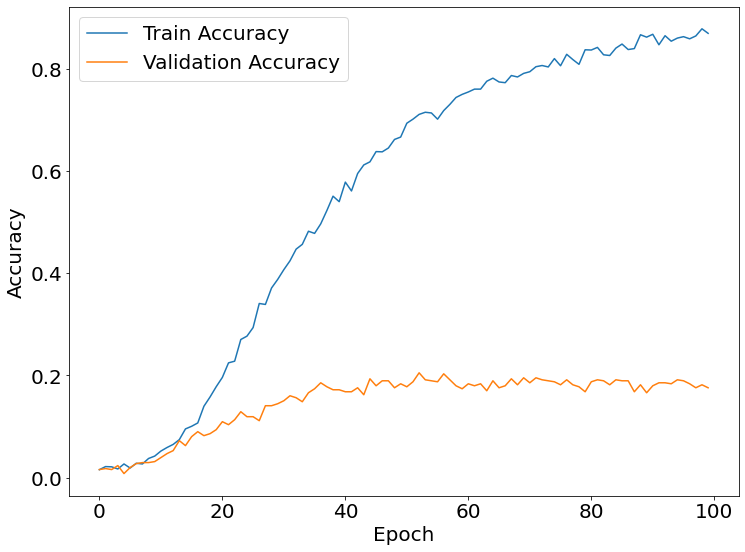

In [47]:
plot_training(final_history, 'person_accuracy.png')

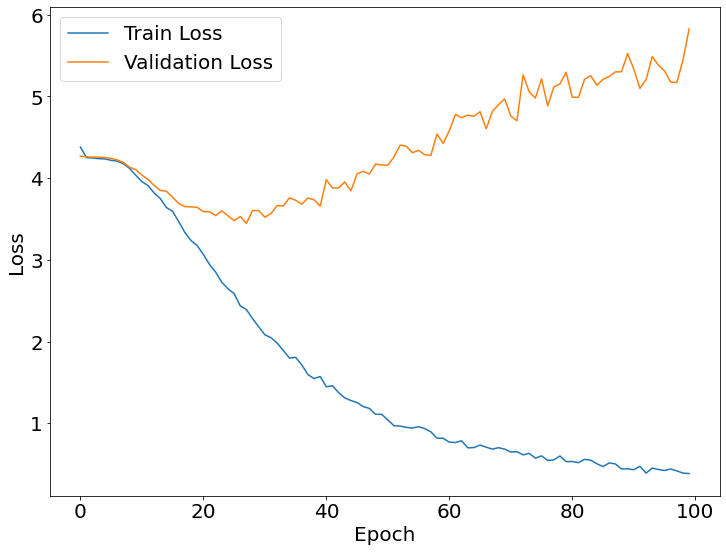

In [48]:
plot_training_loss(final_history, 'person_loss.png')